<a href="https://colab.research.google.com/github/Aqel06/Kelompok-1-KAV/blob/main/Kelompok_1_KAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup & Import

In [29]:
!pip -q install librosa soundfile numpy scipy

import numpy as np
import librosa
import librosa.display
import soundfile as sf
import scipy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Utilitas: Tuning, Nama Nada, Circular Shift

In [30]:
PITCH_CLASSES = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
KEY_NAMES_MAJ = [pc + " major" for pc in PITCH_CLASSES]
KEY_NAMES_MIN = [pc + " minor" for pc in PITCH_CLASSES]

def circular_shift(vec, k):
    """Geser melingkar 12-D (kanan = +k)."""
    k = int(k) % 12
    return np.roll(vec, k)

def normalize_vec(v, eps=1e-8):
    v = np.asarray(v, float)
    n = np.linalg.norm(v) + eps
    return v / n

def cosine_sim(a, b, eps=1e-8):
    a = normalize_vec(a, eps)
    b = normalize_vec(b, eps)
    return float(np.dot(a, b))

### Sintesis Audio Chord Progression

In [31]:
NOTE_TO_SEMITONE = {
    'C':0,'C#':1,'Db':1,'D':2,'D#':3,'Eb':3,'E':4,'F':5,'F#':6,'Gb':6,
    'G':7,'G#':8,'Ab':8,'A':9,'A#':10,'Bb':10,'B':11
}

def midi_to_hz(m):
    return 440.0 * (2.0 ** ((m - 69)/12.0))

def note_to_hz(n, octave=4):
    semitone = NOTE_TO_SEMITONE[n]
    midi = 12*(octave+1) + semitone  # MIDI C4 = 60
    return midi_to_hz(midi)

def synth_chord(notes, dur=1.0, sr=22050, fade=0.01):
    """Sederhana: jumlah sinusoida untuk nada-nada chord."""
    t = np.linspace(0, dur, int(sr*dur), endpoint=False)
    y = np.zeros_like(t)
    for (n, octv) in notes:
        f = note_to_hz(n, octv)
        y += np.sin(2*np.pi*f*t)
    # fade in/out kecil agar tidak klik
    L = len(y)
    fL = int(fade*sr)
    if fL > 0:
        win = np.ones(L)
        win[:fL] = np.linspace(0,1,fL)
        win[-fL:] = np.linspace(1,0,fL)
        y *= win
    y /= np.max(np.abs(y)) + 1e-8
    return y

def parse_chord(symbol):
    """Kembalikan pitch-class triad (root, major/minor)."""
    root_name, quality = symbol.split(':')
    root_pc = NOTE_TO_SEMITONE[root_name]
    if quality.lower().startswith('maj'):
        third = (root_pc + 4) % 12
        fifth = (root_pc + 7) % 12
    else:  # minor
        third = (root_pc + 3) % 12
        fifth = (root_pc + 7) % 12
    return [root_pc, third, fifth]

def pc_to_note(pc):
    return PITCH_CLASSES[pc]

def synth_progression(prog=('C:maj','G:maj','A:min','F:maj'),
                      sr=22050, bpm=96, beats_per_chord=4, base_octave=4):
    beat_dur = 60.0 / bpm
    chord_dur = beats_per_chord * beat_dur
    y_all = []
    for sym in prog:
        pcs = parse_chord(sym)
        # voicing sederhana: root di bass (octave 3), lainnya di 4
        notes = [(pc_to_note(pcs[0]), base_octave-1),
                 (pc_to_note(pcs[1]), base_octave),
                 (pc_to_note(pcs[2]), base_octave)]
        y = synth_chord(notes, dur=chord_dur, sr=sr, fade=0.02)
        y_all.append(y)
    y_all = np.concatenate(y_all)
    y_all /= np.max(np.abs(y_all)) + 1e-8
    return y_all, sr

### Muat Audio (atau Sintesis)

In [32]:
AUDIO_PATH = None
if AUDIO_PATH is None:
    y, sr = synth_progression()
else:
    y, sr = librosa.load(AUDIO_PATH, sr=None, mono=True)

# HPSS agar chroma lebih stabil (fokus komponen harmonik)
y_h, y_p = librosa.effects.hpss(y)


### Hitung CHROMA (CQT) + Beat-Synchronous

In [33]:
# Chroma 12-D
chroma = librosa.feature.chroma_cqt(y=y_h, sr=sr, n_chroma=12)
chroma = librosa.util.normalize(chroma, axis=0)

# Beat-synchronous median (lebih stabil untuk akor/kover)
tempo, beats = librosa.beat.beat_track(y=y_h, sr=sr, trim=False)
beats = librosa.util.fix_frames(beats, x_min=0, x_max=chroma.shape[1]-1)
chroma_beat = librosa.util.sync(chroma, beats, aggregate=np.median)  # 12 x T_beats

print("chroma shape:", chroma.shape, "| beat-sync:", chroma_beat.shape)

chroma shape: (12, 431) | beat-sync: (12, 2)


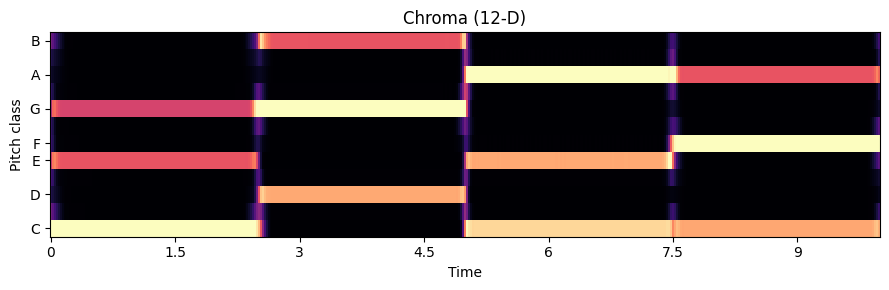

In [34]:
plt.figure(figsize=(9,3))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr)
plt.title("Chroma (12-D)")
plt.tight_layout(); plt.show()

### KEY DETECTION (Scale-based templates — Krumhansl)

In [35]:
# Profil Krumhansl-Schmuckler (normalisasi relatif)
# Sumber umum (skala relatif). Kamu bisa men-tweak bobot.
KS_MAJOR = np.array([6.35,2.23,3.48,2.33,4.38,4.09,2.52,5.19,2.39,3.66,2.29,2.88], float)
KS_MINOR = np.array([6.33,2.68,3.52,5.38,2.60,3.53,2.54,4.75,3.98,2.69,3.34,3.17], float)

def estimate_key_from_chroma(chroma_mat):
    """Ambil mean chroma global → korelasikan ke 24 profil (12 mayor + 12 minor)."""
    avg_c = normalize_vec(np.mean(chroma_mat, axis=1))
    best_sim = -1
    best_key = None

    for k in range(12):
        profM = normalize_vec(circular_shift(KS_MAJOR, k))
        profm = normalize_vec(circular_shift(KS_MINOR, k))
        sM = cosine_sim(avg_c, profM)
        sm = cosine_sim(avg_c, profm)
        if sM > best_sim:
            best_sim = sM
            best_key = KEY_NAMES_MAJ[k]
        if sm > best_sim:
            best_sim = sm
            best_key = KEY_NAMES_MIN[k]
    return best_key, best_sim

key_name, key_score = estimate_key_from_chroma(chroma_beat)
print(f"Estimasi Kunci: {key_name} (skor={key_score:.3f})")

Estimasi Kunci: C major (skor=0.880)


### CHORD RECOGNITION (Chord-based templates — triad mayor/minor)

In [36]:
def build_triads_templates():
    """Bangun 24 template akor (12 mayor, 12 minor)  → matriks 24 x 12."""
    templates = []
    names = []
    base_maj = np.zeros(12); base_maj[[0,4,7]] = [1.0, 0.8, 0.9]  # root > fifth > third (contoh bobot)
    base_min = np.zeros(12); base_min[[0,3,7]] = [1.0, 0.8, 0.9]
    for k in range(12):
        tM = circular_shift(base_maj, k)
        templates.append(tM)
        names.append(PITCH_CLASSES[k] + ":maj")
    for k in range(12):
        tm = circular_shift(base_min, k)
        templates.append(tm)
        names.append(PITCH_CLASSES[k] + ":min")
    templates = np.stack(templates, axis=0)
    # normalisasi tiap template
    templates = np.array([normalize_vec(t) for t in templates])
    return templates, names

TEMPL, CHORD_NAMES = build_triads_templates()

def decode_chords(chroma_sync):
    """Cocokkan tiap kolom (beat) ke template akor (cosine sim)."""
    T = chroma_sync.shape[1]
    labels = []
    scores = []
    for t in range(T):
        v = normalize_vec(chroma_sync[:, t])
        sims = TEMPL @ v
        idx = int(np.argmax(sims))
        labels.append(CHORD_NAMES[idx])
        scores.append(float(sims[idx]))
    return labels, scores

chords, chord_scores = decode_chords(chroma_beat)
for i, (c, s) in enumerate(zip(chords[:12], chord_scores[:12])):
    print(f"Beat {i:02d}: {c} (sim={s:.2f})")

Beat 00: C:maj (sim=0.93)
Beat 01: F:maj (sim=0.94)


### COVER SONG IDENTIFICATION (PTR-style: transposition + time alignment)

Siapkan “lagu B” sebagai “cover” (transposisi + stretch)

In [37]:
yA, srA = y_h, sr
# Simulasikan cover: transpose +2 semitone & sedikit rubato (time-stretch)
yB = librosa.effects.pitch_shift(yA, sr=srA, n_steps=2)
yB = librosa.effects.time_stretch(yB, rate=0.95)

# Chroma beat-synchronous keduanya
def beat_chroma(y, sr):
    ch = librosa.feature.chroma_cqt(y=y, sr=sr, n_chroma=12)
    ch = librosa.util.normalize(ch, axis=0)
    _, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
    beats = librosa.util.fix_frames(beats, x_min=0, x_max=ch.shape[1]-1)
    ch_b = librosa.util.sync(ch, beats, aggregate=np.median)
    return ch_b

XA = beat_chroma(yA, srA)  # 12 x TA
XB = beat_chroma(yB, srA)  # 12 x TB
print("Beat-chroma shapes:", XA.shape, XB.shape)

Beat-chroma shapes: (12, 2) (12, 2)


Optimal Transposition Index (OTI)

In [38]:
def optimal_transposition_index(A, B):
    """Cari shift 0..11 yang memaksimalkan kemiripan rata-rata antar frame (kasar)."""
    # Samakan panjang dengan min(TA, TB) untuk estimasi cepat
    T = min(A.shape[1], B.shape[1])
    A1 = A[:, :T]; B1 = B[:, :T]
    best_k, best_sim = 0, -1
    for k in range(12):
        Bk = np.roll(B1, k, axis=0)
        # cosine sim per frame, lalu rata-rata
        sims = np.sum(normalize_vec(A1,1e-8)*normalize_vec(Bk,1e-8), axis=0)
        s = float(np.mean(sims))
        if s > best_sim:
            best_sim = s
            best_k = k
    return best_k, best_sim

oti, rough_sim = optimal_transposition_index(XA, XB)
print(f"OTI (shift pitch-class terbaik) = +{oti} semitone-class, mean-sim ~ {rough_sim:.3f}")

OTI (shift pitch-class terbaik) = +10 semitone-class, mean-sim ~ 0.487


DTW setelah transposition alignment

In [39]:
# Rotasi XB sesuai OTI
XB_shift = np.roll(XB, oti, axis=0)

# Normalisasi kolom (tiap beat vektor 12-D)
def col_norm(X, eps=1e-8):
    Xn = X.copy()
    for i in range(X.shape[1]):
        n = np.linalg.norm(X[:, i]) + eps
        Xn[:, i] /= n
    return Xn

XA_n = col_norm(XA)
XB_n = col_norm(XB_shift)

# Hitung "jarak" antar beat: 1 - cosine
D = 1.0 - (XA_n.T @ XB_n)  # (TA x TB)

# DTW (cost minimal)
# (librosa >= 0.10): librosa.sequence.dtw
wp, cost_mat = librosa.sequence.dtw(C=D, subseq=True)  # subseq: cover bisa lebih pendek
wp = wp.astype(int) # Convert to integer type
dtw_cost = cost_mat[wp[-1,0], wp[-1,1]]
# Skor kemiripan sederhana
sim_score = 1.0 / (1.0 + dtw_cost / (len(wp)+1e-8))
print(f"DTW cost = {dtw_cost:.2f} → similarity score ≈ {sim_score:.3f}")

DTW cost = 1.00 → similarity score ≈ 0.667


Pitch Transition Representation (12×12)

In [40]:
def pitch_transition_matrix(chroma_sync):
    """Bangun matriks transisi 12x12 dari urutan pitch-class dominan per beat."""
    # ambil argmax per beat → urutan pitch class
    seq = np.argmax(chroma_sync, axis=0)
    M = np.zeros((12,12), float)
    for i in range(len(seq)-1):
        a, b = seq[i], seq[i+1]
        M[a, b] += 1.0
    # normalisasi baris (probabilitas transisi)
    row_sums = M.sum(axis=1, keepdims=True) + 1e-8
    M /= row_sums
    return M

MA = pitch_transition_matrix(XA)
MB = pitch_transition_matrix(XB_shift)

# cari rotasi terbaik (0..11) untuk meminimalkan jarak Frobenius
best_k, best_dist = 0, 1e9
for k in range(12):
    MBk = np.roll(np.roll(MB, k, axis=0), k, axis=1)  # rotasi baris & kolom
    dist = np.linalg.norm(MA - MBk, ord='fro')
    if dist < best_dist:
        best_k, best_dist = k, dist

print(f"PTR/Transition match best-shift=+{best_k}, Frobenius dist={best_dist:.3f}")

PTR/Transition match best-shift=+0, Frobenius dist=1.414
